In [1]:
from collections.abc import Iterable
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import numba
import correctionlib
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
@numba.jit
def get_matching_pairs_indices(idx_quark, idx_jets, builder, builder2):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        builder2.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done:
                if j not in j_done:
                    builder.append(i)
                    q_done.append(q)
                    j_done.append(j)
                else: 
                    builder2.append(i)
        builder.end_list()
        builder2.end_list()
    return builder, builder2

def metric_pt(obj, obj2):
    return abs(obj.pt - obj2.pt)

def object_matching(obj, obj2, dr_min, pt_min=None):
    # Compute deltaR(quark, jet) and save the nearest jet (deltaR matching)
    deltaR = ak.flatten(obj.metric_table(obj2), axis=2)
    # Keeping only the pairs with a deltaR min
    maskDR = deltaR < dr_min
    if pt_min is not None:
        deltaPt_table = obj.metric_table(obj2, metric=metric_pt)
        # Check if the pt cut is an iterable or a scalar
        if isinstance(pt_min, Iterable):
            # Broadcast and flatten pt_min array in order to match the shape of the metric_table()
            pt_min_broadcast, deltaPt_table_broadcast  = ak.broadcast_arrays(pt_min[:,np.newaxis], deltaPt_table)
            pt_min  = ak.flatten(pt_min_broadcast, axis=2)
        deltaPt = ak.flatten(deltaPt_table, axis=2)
        maskPt = deltaPt < pt_min
        maskDR = maskDR & maskPt
    deltaRcut = deltaR[maskDR]
    idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
    pairs = ak.argcartesian([obj, obj2])[maskDR]
    pairs_sorted = pairs[idx_pairs_sorted]
    idx_obj, idx_obj2 = ak.unzip(pairs_sorted)
    
    _idx_matched_pairs, _idx_missed_pairs = get_matching_pairs_indices(idx_obj, idx_obj2, ak.ArrayBuilder(), ak.ArrayBuilder())
    idx_matched_pairs = _idx_matched_pairs.snapshot()
    idx_missed_pairs = _idx_missed_pairs.snapshot()
    # The invalid jet matches result in a None value. Only non-None values are selected.
    matched_obj  = obj[idx_obj[idx_matched_pairs]]
    matched_obj2 = obj2[idx_obj2[idx_matched_pairs]]
    deltaR_matched = deltaRcut[idx_matched_pairs]

    return matched_obj, matched_obj2, deltaR_matched

In order to apply the JER smearing, we have to match the jets to the corresponding gen-level jets.
To do that, we require $\Delta$R to be less than half the jet cone radius. In addition we require that the absolute difference between the jet and gen-level jet $p_T$ is less than $3\sigma_{JER}p_T$, where $\sigma_{JER}$ is the jet $p_T$ resolution as read from the JER correction file.

In [3]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100000).events()

Here, as an example, we apply a cut on $p_T$ at 15 GeV to check that the implementation of the cut using `metric_table()` does what we expect.

In [4]:
pt_min = 15
matched_genjets, matched_jets, deltaR_matched = object_matching(events.GenJet, events.Jet, 0.2)
matched_genjets_pt, matched_jets_pt, deltaR_matched_pt = object_matching(events.GenJet, events.Jet, 0.2, pt_min=pt_min)
matched_jets.pt

<Array [[75.2, 178, 19.5, ... 85.5, 56, 29]] type='100000 * var * float32[parame...'>

In [5]:
matched_genjets.pt

<Array [[70.8, 187, 13.8, ... 49.3, 28.8]] type='100000 * var * float32[paramete...'>

In [6]:
deltaPt    = ak.flatten(matched_jets.pt - matched_genjets.pt)
deltaPt_pt = ak.flatten(matched_jets_pt.pt - matched_genjets_pt.pt)
deltaPt

<Array [4.34, -8.74, 5.64, ... 6.72, 0.154] type='837024 * float32'>

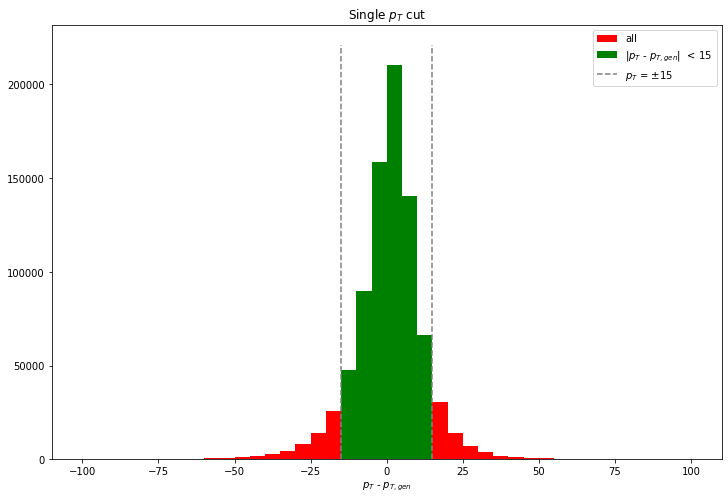

In [7]:
plt.figure(figsize=[12,8])
n, bins, patches = plt.hist(deltaPt, bins=np.linspace(-100, 100, 41), color='red', label="all");
plt.hist(deltaPt_pt, bins=np.linspace(-100, 100, 41), color='green', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min}");
plt.xlabel("$p_T$ - $p_{T,gen}$");
plt.vlines([-pt_min, pt_min], 0, 1.05*max(n), linestyle='dashed', color='grey', label=f"$p_T$ = $\pm${pt_min}")
plt.title("Single $p_T$ cut")
plt.legend();
#plt.hist(deltaPt);

When we want to take into account the JER and smear the jet $p_T$, the cut on the absolute $p_T$ difference is not a single number but an array since the jet $p_T$ resolution depends in general on ($p_T$, $\eta$, $\rho$) of the jet.

In [8]:
ones = ak.ones_like(events.event)
pt_min = ak.concatenate((10*ones[:33], 15*ones[33:66], 20*ones[66:]))
matched_genjets, matched_jets, deltaR_matched = object_matching(events.GenJet, events.Jet, 0.2)
matched_genjets_pt, matched_jets_pt, deltaR_matched_pt = object_matching(events.GenJet, events.Jet, 0.2, pt_min=pt_min)
matched_jets.pt

<Array [[75.2, 178, 19.5, ... 85.5, 56, 29]] type='100000 * var * float32[parame...'>

In [9]:
deltaPt    = ak.flatten(matched_jets.pt - matched_genjets.pt)
deltaPt_pt = ak.flatten(matched_jets_pt.pt - matched_genjets_pt.pt)
deltaPt

<Array [4.34, -8.74, 5.64, ... 6.72, 0.154] type='837024 * float32'>

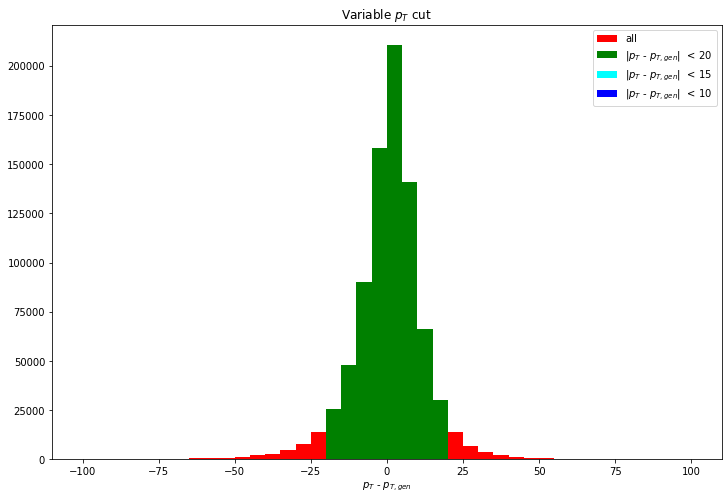

In [10]:
plt.figure(figsize=[12,8])
n, bins, patches = plt.hist(deltaPt, bins=np.linspace(-100, 100, 41), color='red', label="all");
plt.hist(deltaPt_pt[66:], bins=np.linspace(-100, 100, 41), color='green', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min[66]}");
plt.hist(deltaPt_pt[33:66], bins=np.linspace(-100, 100, 41), color='cyan', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min[33]}");
plt.hist(deltaPt_pt[:33], bins=np.linspace(-100, 100, 41), color='blue', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min[0]}");
plt.xlabel("$p_T$ - $p_{T,gen}$");
plt.title("Variable $p_T$ cut")
plt.legend();
#plt.hist(deltaPt);

In [11]:
jsonfile = "/work/mmarcheg/POG/JME/2018UL/jet_jerc.json"
JERversion = "Summer19UL18_JRV2_MC"
typeJet = "AK4PFchs"
JECfile = correctionlib.CorrectionSet.from_file(jsonfile)
sf  = JECfile[f'{JERversion}_ScaleFactor_{typeJet}']
res = JECfile[f'{JERversion}_PtResolution_{typeJet}']

In [12]:
def object_matching_minimal(obj, obj2, dr_min, pt_min=None):
    # Compute deltaR(quark, jet) and save the nearest jet (deltaR matching)
    deltaR  = ak.flatten(obj.metric_table(obj2), axis=2)
    # keeping only the pairs with a deltaR min
    maskDR = deltaR < dr_min
    if pt_min is not None:
        deltaPt_table = obj.metric_table(obj2, metric=metric_pt)
        #pt_min_table  = ak.broadcast_arrays(pt_min, deltaPt_table)
        deltaPt = ak.flatten(deltaPt_table, axis=2)
        #pt_min  = ak.flatten(pt_min_table, axis=2)
    return deltaPt_table, deltaPt

pt_min = 3*0.05*events.Jet.pt
deltaPt_table, deltaPt = object_matching_minimal(events.GenJet, events.Jet, 0.2, pt_min=pt_min)
#deltaPt[0].tolist()

In [13]:
deltaPt_table[0].tolist()

[[8.7435302734375,
  91.8685302734375,
  111.8060302734375,
  135.4310302734375,
  143.3685302734375,
  151.7747802734375,
  151.9622802734375,
  158.6966552734375,
  164.6185302734375,
  167.5091552734375],
 [81.65145874023438,
  1.473541259765625,
  21.411041259765625,
  45.036041259765625,
  52.973541259765625,
  61.379791259765625,
  61.567291259765625,
  68.30166625976562,
  74.22354125976562,
  77.11416625976562],
 [107.40642547607422,
  24.28142547607422,
  4.343925476074219,
  19.28107452392578,
  27.21857452392578,
  35.62482452392578,
  35.81232452392578,
  42.54669952392578,
  48.46857452392578,
  51.35919952392578],
 [131.35952758789062,
  48.23453140258789,
  28.29703140258789,
  4.672031402587891,
  3.2654685974121094,
  11.67171859741211,
  11.85921859741211,
  18.59359359741211,
  24.51546859741211,
  27.40609359741211],
 [132.83938598632812,
  49.714378356933594,
  29.776878356933594,
  6.151878356933594,
  1.7856216430664062,
  10.191871643066406,
  10.379371643066406

In [14]:
deltaPt[0].tolist()

[8.7435302734375,
 91.8685302734375,
 111.8060302734375,
 135.4310302734375,
 143.3685302734375,
 151.7747802734375,
 151.9622802734375,
 158.6966552734375,
 164.6185302734375,
 167.5091552734375,
 81.65145874023438,
 1.473541259765625,
 21.411041259765625,
 45.036041259765625,
 52.973541259765625,
 61.379791259765625,
 61.567291259765625,
 68.30166625976562,
 74.22354125976562,
 77.11416625976562,
 107.40642547607422,
 24.28142547607422,
 4.343925476074219,
 19.28107452392578,
 27.21857452392578,
 35.62482452392578,
 35.81232452392578,
 42.54669952392578,
 48.46857452392578,
 51.35919952392578,
 131.35952758789062,
 48.23453140258789,
 28.29703140258789,
 4.672031402587891,
 3.2654685974121094,
 11.67171859741211,
 11.85921859741211,
 18.59359359741211,
 24.51546859741211,
 27.40609359741211,
 132.83938598632812,
 49.714378356933594,
 29.776878356933594,
 6.151878356933594,
 1.7856216430664062,
 10.191871643066406,
 10.379371643066406,
 17.113746643066406,
 23.035621643066406,
 25.926

In [15]:
deltaPt_table.tolist()

[[[8.7435302734375,
   91.8685302734375,
   111.8060302734375,
   135.4310302734375,
   143.3685302734375,
   151.7747802734375,
   151.9622802734375,
   158.6966552734375,
   164.6185302734375,
   167.5091552734375],
  [81.65145874023438,
   1.473541259765625,
   21.411041259765625,
   45.036041259765625,
   52.973541259765625,
   61.379791259765625,
   61.567291259765625,
   68.30166625976562,
   74.22354125976562,
   77.11416625976562],
  [107.40642547607422,
   24.28142547607422,
   4.343925476074219,
   19.28107452392578,
   27.21857452392578,
   35.62482452392578,
   35.81232452392578,
   42.54669952392578,
   48.46857452392578,
   51.35919952392578],
  [131.35952758789062,
   48.23453140258789,
   28.29703140258789,
   4.672031402587891,
   3.2654685974121094,
   11.67171859741211,
   11.85921859741211,
   18.59359359741211,
   24.51546859741211,
   27.40609359741211],
  [132.83938598632812,
   49.714378356933594,
   29.776878356933594,
   6.151878356933594,
   1.785621643066406

In [16]:
pt_min_broadcast, deltaPt_table_broadcast = ak.broadcast_arrays(pt_min[:,np.newaxis], deltaPt_table)
ak.flatten(pt_min_broadcast, axis=2).tolist()

KeyboardInterrupt: 

In [17]:
pt_min = 3*0.05*events.Jet.pt
matched_genjets, matched_jets, deltaR_matched = object_matching(events.GenJet, events.Jet, 0.2, pt_min=pt_min)

In [18]:
matched_jets.pt[0].tolist()

[75.1875, 178.25, 51.5625, 95.125, 43.625, 35.21875]

In [19]:
matched_genjets.pt[0].tolist()

[70.84357452392578,
 186.9935302734375,
 46.89046859741211,
 96.59854125976562,
 45.410621643066406,
 37.62003707885742]

In [20]:
deltaPt = ak.flatten(matched_jets.pt - matched_genjets.pt)
deltaPt

<Array [4.34, -8.74, 4.67, ... 6.72, 0.154] type='539292 * float32'>

In [21]:
jsonfile = '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/JME/2017_UL/jet_jerc.json.gz'
JECfile = correctionlib.CorrectionSet.from_file(jsonfile)
corrected_jets = events.Jet
corrected_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, events.Jet.pt)[0]

JERversion = "Summer19UL17_JRV2_MC"
typeJet    = "AK4PFchs"
sf  = JECfile[f'{JERversion}_ScaleFactor_{typeJet}']
res = JECfile[f'{JERversion}_PtResolution_{typeJet}']
genjets = events['GenJet']
j, nj   = ak.flatten(corrected_jets), ak.num(corrected_jets)
gj, ngj = ak.flatten(genjets), ak.num(genjets)
flatScaleFactor  = sf.evaluate(j['eta'].to_numpy(), 'nom')
flatPtResolution = res.evaluate(j['eta'].to_numpy(), j['pt'].to_numpy(), j['rho'].to_numpy())
scaleFactor  = ak.unflatten(flatScaleFactor, nj)
ptResolution = ak.unflatten(flatPtResolution, nj)
# Match jets with gen-level jets, with DeltaR and DeltaPt requirements
dr_min = {'AK4PFchs' : 0.2, 'AK8PFPuppi' : 0.4}[typeJet]  # Match jets within a cone with half the jet radius
pt_min = 3 * ptResolution * corrected_jets['pt']          # Match jets whose pt does not differ more than 3 sigmas from the gen-level pt
matched_genjets, matched_jets, deltaR_matched = object_matching(genjets, corrected_jets, dr_min, pt_min)
#corrFactor = 1 + (scaleFactor - 1) * (matched_jets['pt'] - matched_genjets['pt']) / matched_jets['pt']
#print("matched_genjets", matched_genjets.pt)
print("jets", corrected_jets.pt)
print("matched_jets", matched_jets.pt)

jets [[178, 95.1, 75.2, 51.6, 43.6, 35.2, 35, ... 61.5, 56, 54.2, 46.1, 34.6, 29, 20.7]]
matched_jets [[75.2, 178, 19.5, 51.6, 95.1, 22.4, 43.6, ... 54.2, 95.6, 34.6, 61.5, 85.5, 56, 29]]


In [22]:
deltaPt = ak.flatten(matched_jets.pt - matched_genjets.pt)
deltaPt

<Array [4.34, -8.74, 5.64, ... 6.72, 0.154] type='816880 * float32'>

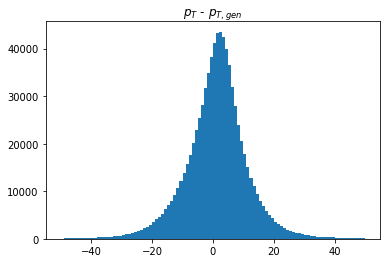

In [23]:
plt.hist(deltaPt, bins=np.linspace(-50, 50, 101))
plt.title("$p_T$ - $p_{T,gen}$");

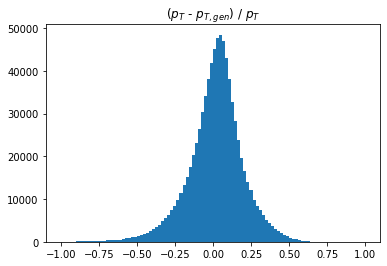

In [24]:
resolution = deltaPt/ak.flatten(matched_jets.pt)
plt.hist(resolution, bins=np.linspace(-1, 1, 101))
plt.title("($p_T$ - $p_{T,gen}$) / $p_T$");

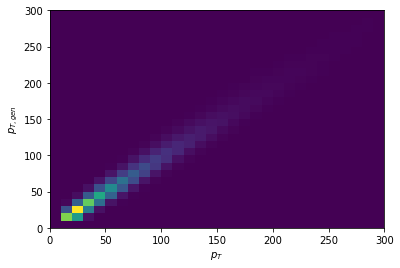

In [25]:
nbins = 30
plt.hist2d(ak.flatten(matched_jets.pt), ak.flatten(matched_genjets.pt), bins=(np.linspace(0,300,nbins+1), np.linspace(0,300,nbins+1)))
plt.xlabel("$p_T$")
plt.ylabel("$p_{T,gen}$");

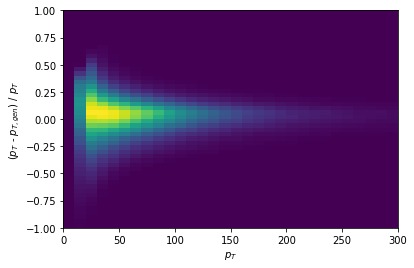

In [26]:
nbins = 30
nbins_res = 50
plt.hist2d(ak.flatten(matched_jets.pt), resolution, bins=(np.linspace(0,300,nbins+1), np.linspace(-1,1,nbins_res+1)))
plt.xlabel("$p_T$")
plt.ylabel("($p_T$ - $p_{T,gen}$) / $p_T$");

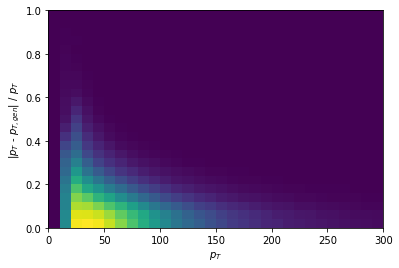

In [27]:
nbins = 30
plt.hist2d(ak.flatten(matched_jets.pt), abs(resolution), bins=(np.linspace(0,300,nbins+1), np.linspace(0,1,int(nbins_res/2)+1)))
plt.xlabel("$p_T$")
plt.ylabel("|$p_T$ - $p_{T,gen}$| / $p_T$");

In [28]:
scaleFactor

<Array [[1.09, 1.11, 1.09, ... 1.09, 1.12]] type='100000 * var * float64'>

In [29]:
ak.count(scaleFactor, axis=1)

<Array [10, 9, 10, 8, 5, 7, ... 9, 18, 9, 8, 9] type='100000 * int64'>

In [30]:
ak.count(matched_jets.pt, axis=1)

<Array [10, 7, 9, 8, 5, 5, ... 9, 10, 9, 6, 8] type='100000 * int64'>

In [31]:
ak.count(matched_genjets.pt, axis=1)

<Array [10, 7, 9, 8, 5, 5, ... 9, 10, 9, 6, 8] type='100000 * int64'>

In [32]:
def object_matching_new(obj, obj2, dr_min, pt_min=None):
    # Compute deltaR(quark, jet) and save the nearest jet (deltaR matching)
    deltaR_table = obj.metric_table(obj2)
    deltaR = ak.flatten(deltaR_table, axis=2)
    # Keeping only the pairs with a deltaR min
    maskDR = deltaR < dr_min
    if pt_min is not None:
        deltaPt_table = obj.metric_table(obj2, metric=metric_pt)
        # Check if the pt cut is an iterable or a scalar
        if isinstance(pt_min, Iterable):
            # Broadcast and flatten pt_min array in order to match the shape of the metric_table()
            pt_min_broadcast, deltaPt_table_broadcast  = ak.broadcast_arrays(pt_min[:,np.newaxis], deltaPt_table)
            pt_min  = ak.flatten(pt_min_broadcast, axis=2)
        deltaPt = ak.flatten(deltaPt_table, axis=2)
        maskPt = deltaPt < pt_min
        #maskDR = maskDR & maskPt
        maskDR = maskDR
    #deltaRcut = deltaR[maskDR]
    idx_pairs_sorted = ak.argsort(deltaR, axis=1)
    idx_pairs_pass_sorted = ak.argsort(deltaR[maskDR], axis=1)
    pairs = ak.argcartesian([obj, obj2])
    #pairs_pass = ak.argcartesian([obj, obj2])[maskDR]
    pairs_sorted = pairs[idx_pairs_sorted]
    pairs_pass_sorted = pairs[idx_pairs_pass_sorted]
    idx_obj, idx_obj2 = ak.unzip(pairs_sorted)
    # Save the indices of the objects passing the DR+pt cut
    idx_obj_pass, idx_obj2_pass = ak.unzip(pairs_sorted[maskDR])
    
    _idx_matched_pairs, _idx_missed_pairs = get_matching_pairs_indices(idx_obj, idx_obj2, ak.ArrayBuilder(), ak.ArrayBuilder())
    idx_matched_pairs = _idx_matched_pairs.snapshot()
    idx_missed_pairs = _idx_missed_pairs.snapshot()
    # The invalid jet matches result in a None value. Only non-None values are selected.
    idx_matched_obj  = idx_obj[idx_matched_pairs]
    idx_matched_obj2 = idx_obj2[idx_matched_pairs]
    matched_obj  = obj[idx_matched_obj]
    matched_obj2 = obj2[idx_matched_obj2]
    deltaR_matched = deltaR[idx_matched_pairs]
    
    matched_obj  = ak.where(maskDR, matched_obj, None)
    matched_obj2 = ak.where(maskDR, matched_obj2, None)
    deltaR_matched = ak.where(maskDR, deltaR_matched, None)

    #return matched_obj, matched_obj2, deltaR_matched, idx_matched_pairs, idx_missed_pairs
    return matched_obj, matched_obj2, deltaR_matched, maskDR, pairs_sorted

In [33]:
obj = genjets
obj2 = corrected_jets
dr_min = {'AK4PFchs' : 0.2, 'AK8PFPuppi' : 0.4}[typeJet]  # Match jets within a cone with half the jet radius
pt_min = 3 * ptResolution * corrected_jets['pt']          # Match jets whose pt does not differ more than 3 sigmas from the gen-level pt
deltaR_table = obj.metric_table(obj2)
deltaR = ak.flatten(deltaR_table, axis=2)
# Keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
if pt_min is not None:
    deltaPt_table = obj.metric_table(obj2, metric=metric_pt)
    # Check if the pt cut is an iterable or a scalar
    if isinstance(pt_min, Iterable):
        # Broadcast and flatten pt_min array in order to match the shape of the metric_table()
        pt_min_broadcast, deltaPt_table_broadcast  = ak.broadcast_arrays(pt_min[:,np.newaxis], deltaPt_table)
        pt_min  = ak.flatten(pt_min_broadcast, axis=2)
    deltaPt = ak.flatten(deltaPt_table, axis=2)
    maskPt = deltaPt < pt_min
    maskDR = maskDR & maskPt1010
    #maskDR = maskDR
#deltaRcut = deltaR[maskDR]
idx_pairs_sorted = ak.argsort(deltaR, axis=1)
#idx_pairs_pass_sorted = ak.argsort(deltaR[maskDR], axis=1)
pairs = ak.argcartesian([obj, obj2])
#pairs_pass = ak.argcartesian([obj, obj2])[maskDR]
pairs_sorted = pairs[idx_pairs_sorted]
deltaR_sorted = deltaR[idx_pairs_sorted]
maskDR_sorted = maskDR[idx_pairs_sorted]
#pairs_pass_sorted = pairs[idx_pairs_pass_sorted]
idx_obj, idx_obj2 = ak.unzip(pairs_sorted)
# Save the indices of the objects passing the DR+pt cut
#idx_obj_pass, idx_obj2_pass = ak.unzip(pairs_sorted[maskDR])

_idx_matched_pairs, _idx_missed_pairs = get_matching_pairs_indices(idx_obj, idx_obj2, ak.ArrayBuilder(), ak.ArrayBuilder())
idx_matched_pairs = _idx_matched_pairs.snapshot()
idx_missed_pairs = _idx_missed_pairs.snapshot()
# The invalid jet matches result in a None value. Only non-None values are selected.
idx_matched_obj  = idx_obj[idx_matched_pairs]
idx_matched_obj2 = idx_obj2[idx_matched_pairs]
matched_obj  = obj[idx_matched_obj]
matched_obj2 = obj2[idx_matched_obj2]
deltaR_matched = deltaR_sorted[idx_matched_pairs]
maskDR_matched = maskDR_sorted[idx_matched_pairs]

In [34]:
obj = genjets
obj2 = corrected_jets 
dr_min = {'AK4PFchs' : 0.2, 'AK8PFPuppi' : 0.4}[typeJet]  # Match jets within a cone with half the jet radius
pt_min = 3 * ptResolution * corrected_jets['pt']          # Match jets whose pt does not differ more than 3 sigmas from the gen-level pt

deltaR_table = obj.metric_table(obj2)
deltaR = ak.flatten(deltaR_table, axis=2)
# Keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
if pt_min is not None:
    deltaPt_table = obj.metric_table(obj2, metric=metric_pt)
    # Check if the pt cut is an iterable or a scalar
    if isinstance(pt_min, Iterable):
        # Broadcast and flatten pt_min array in order to match the shape of the metric_table()
        pt_min_broadcast, deltaPt_table_broadcast  = ak.broadcast_arrays(pt_min[:,np.newaxis], deltaPt_table)
        pt_min  = ak.flatten(pt_min_broadcast, axis=2)
    deltaPt = ak.flatten(deltaPt_table, axis=2)
    maskPt = deltaPt < pt_min
    maskDR = maskDR & maskPt
    #maskDR = maskDR
#deltaRcut = deltaR[maskDR]
idx_pairs_sorted = ak.argsort(deltaR, axis=1)
pairs = ak.argcartesian([obj, obj2])
#pairs_pass = ak.argcartesian([obj, obj2])[maskDR]
pairs_sorted = pairs[idx_pairs_sorted]
deltaR_sorted = deltaR[idx_pairs_sorted]
maskDR_sorted = maskDR[idx_pairs_sorted]
idx_obj, idx_obj2 = ak.unzip(pairs_sorted)

_idx_matched_pairs, _idx_missed_pairs = get_matching_pairs_indices(idx_obj, idx_obj2, ak.ArrayBuilder(), ak.ArrayBuilder())
idx_matched_pairs = _idx_matched_pairs.snapshot()
idx_missed_pairs = _idx_missed_pairs.snapshot()
# The invalid jet matches result in a None value. Only non-None values are selected.
idx_matched_obj  = idx_obj[idx_matched_pairs]
idx_matched_obj2 = idx_obj2[idx_matched_pairs]
matched_obj  = obj[idx_matched_obj]
matched_obj2 = obj2[idx_matched_obj2]
deltaR_matched = deltaR_sorted[idx_matched_pairs]
maskDR_matched = maskDR_sorted[idx_matched_pairs]

In [35]:
i = 15

In [36]:
idx_matched_obj[i].tolist()

[5, 0, 2, 1, 6, 3, 8, 4, 7]

In [37]:
idx_matched_obj2[i].tolist()

[4, 0, 2, 1, 7, 3, 10, 6, 5]

In [38]:
deltaR[idx_matched_pairs][i].tolist()

[0.010021667927503586,
 2.4056615829467773,
 2.4392249584198,
 2.5364043712615967,
 2.9923346042633057,
 1.175989031791687,
 1.7356089353561401,
 1.125065565109253,
 2.742898941040039]

In [39]:
jet_order_index = ak.argsort(idx_matched_obj2) # index = indice pt ==> jet ordinati per pt

In [40]:
jet_order_index[i]

<Array [1, 3, 2, 5, 0, 8, 7, 4, 6] type='9 * int64'>

In [41]:
idx_genjet_ordered = idx_matched_obj[jet_order_index]
idx_jet_ordered= idx_matched_obj2[jet_order_index]
genjet_final = obj[idx_genjet_ordered]
jet_final = obj2[idx_jet_ordered]
deltaR_ordered =  deltaR_matched[jet_order_index]
mask_ordered =  maskDR_matched[jet_order_index]

In [42]:
idx_genjet_ordered[i]

<Array [0, 1, 2, 3, 5, 7, 4, 6, 8] type='9 * int64'>

In [43]:
idx_jet_ordered[i]

<Array [0, 1, 2, 3, 4, 5, 6, 7, 10] type='9 * int64'>

In [44]:
genjet_final.pt[i].tolist()

[138.8302459716797,
 105.719970703125,
 60.76750564575195,
 45.78376007080078,
 42.01175308227539,
 24.973873138427734,
 42.75089645385742,
 32.68873596191406,
 20.38734245300293]

In [45]:
jet_final.pt[i].tolist()

[136.75,
 100.0,
 61.3125,
 53.4375,
 51.15625,
 46.0625,
 39.84375,
 30.90625,
 17.265625]

In [46]:
deltaR_matched[i].tolist()

[0.009599415585398674,
 0.010021667927503586,
 0.02221008948981762,
 0.02249971404671669,
 0.02250865288078785,
 0.028414864093065262,
 0.033886827528476715,
 0.06163635477423668,
 0.0732421875]

In [47]:
deltaR_ordered[i].tolist()

[0.010021667927503586,
 0.02249971404671669,
 0.02221008948981762,
 0.028414864093065262,
 0.009599415585398674,
 0.0732421875,
 0.06163635477423668,
 0.02250865288078785,
 0.033886827528476715]

In [48]:
mask_ordered[i].tolist()

[True, True, True, True, True, True, True, True, True]

In [49]:
genjet_final_masked = ak.mask(genjet_final, mask_ordered)

In [50]:
genjet_final_masked.pt[i]

<Array [139, 106, 60.8, ... 42.8, 32.7, 20.4] type='9 * ?float32[parameters={"__...'>

In [67]:
@numba.jit
def fill_not_matched(genjet, idx_jets_matched, num_jets, builder):
    for idx_jet, nj, genj in zip(idx_jets_matched, num_jets, genjet):
        builder.begin_list()
        curr_idx_jet = 0
        nmatched = len(idx_jet)
        
        for ij in range(nmatched-1):
            builder.append(genj[ij])
            diff = idx_jet[ij+1] - idx_jet[ij]
            if diff > 1:
                for k in range(diff-1):
                    # fill none
                    builder.append(None)
        
        #Add the last one
        builder.append(genj[-1])
        #index of the last matched jet
        last = idx_jet[-1]
        if last < (nj-1):
            for k in range(nj-last-1):
                # fill none
                builder.append(None)
        builder.end_list()

    return builder

In [ ]:
Z = fill_not_matched(genjet_final, idx_jet_ordered, ak.num(obj2), ak.ArrayBuilder()).snapshot()

/tmp/ipykernel_22864/2105121389.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fill_not_matched" failed type inference due to: - Resolution failure for literal arguments:
ak.RecordViewType(ak.ArrayView(ak.RecordArrayType((ak.VirtualArrayType({"class":"NumpyArray","inner_shape":[],"itemsize":4,"format":"f","primitive":"float32","has_identities":false,"parameters":{"__doc__":"eta"},"form_key":"GenJet_eta%2C%21load%2C%21content"}, none, {}), ak.VirtualArrayType({"class":"NumpyArray","inner_shape":[],"itemsize":4,"format":"f","primitive":"float32","has_identities":false,"parameters":{"__doc__":"mass"},"form_key":"GenJet_mass%2C%21load%2C%21content"}, none, {}), ak.VirtualArrayType({"class":"NumpyArray","inner_shape":[],"itemsize":4,"format":"f","primitive":"float32","has_identities":false,"parameters":{"__doc__":"phi"},"form_key":"GenJet_phi%2C%21load%2C%21content"}, none, {}), ak.VirtualArrayType({"class":"NumpyArray","inner_shap

In [57]:
Z = fill_not_matched(genjet_final, idx_jet_ordered, ak.num(obj2), ak.ArrayBuilder()).snapshot()

In [62]:
idx_jet_ordered

<Array [[0, 1, 2, 3, 4, 5, ... 4, 5, 6, 7, 8]] type='100000 * var * int64'>

In [53]:
i =25
idx_jet_ordered[i]

<Array [0, 1, 2, 3, 4, 5, 6, 7, 10, 11] type='10 * int64'>

In [54]:
genjet_final[i]

<PtEtaPhiMCollectionArray [{eta: -1.26, ... hadronFlavour: 0}] type='10 * struct...'>

ValueError: x and y must be the same size

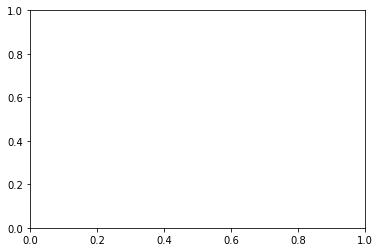

In [58]:
plt.scatter(ak.num(Z), ak.num(obj2))

In [ ]:
Z[i].pt.tolist()
